In [4]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import math
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))

In [5]:
df = pd.read_excel("Controls_dictionnary_202110_A.xlsx", sheet_name="ALL_ANONYMISED")

In [6]:
def measure_words_similarity(word1, word2):
    """
    Return difference in terms of distance between two words
    
    word1: String
    word2: String
    
    Example:
    measure_words_similarity("Women","Woman")
    >>>0.2
    """
    word1, word2 = word1.lower(), word2.lower()
    return nltk.edit_distance(word1, word2)/max(len(word1), len(word2))

def normalise_list_of_words(listA, listB, treshold_word_similarity = 0.3):
    """
    Returns a matrix with similarities between words from 2 lists 
    
    listA: List
    listB: List
    treshold_word_similarity: int, by default 0.3
    
    Example:
    normalise_list_of_words(["Women","Man","School", "Children"],["Woman","School", "Teacher"])
    >>>(['School', 'Women', 'Children', 'Man'],
         ['Teacher', 'School', 'Women'],
                   Woman  School   Teacher
         Women     0.200   1.000  0.857143
         Man       0.400   1.000  0.857143
         School    1.000   0.000  0.857143
         Children  0.875   0.875  0.875000)
    """
    maxtrix_similarity = np.zeros((len(listA),len(listB)))
    for i in range(len(listA)):
        for j in range(len(listB)):
            word1 = listA[i]
            word2 = listB[j]
            maxtrix_similarity[i,j] = measure_words_similarity(word1, word2)
    df = pd.DataFrame(maxtrix_similarity)
    df.columns = listB
    df.index = listA


    seen_A = []
    seen_B = []
    for i in range(len(listA)):
        for j in range(len(listB)):
            if listA[i] in set(seen_A).union(seen_B) or listB[j] in set(seen_A).union(seen_B):
                continue
            if maxtrix_similarity[i,j] < treshold_word_similarity and maxtrix_similarity[i,j]>0:
                seen_A.append(listA[i])
                seen_B.append(listB[j])
    updated_listA = (set(listA) - set(seen_A).union(set(seen_B))).union(set(seen_A))
    updated_listB = (set(listB) - set(seen_B).union(set(seen_A))).union(set(seen_A))     
    return  list(updated_listA), list(updated_listB), df

def tokenize_sentence(input_sentence):
    """
    Return list of tokenized input_sentence
    
    input_sentence: String
    
    Example:
    tokenize_sentence("This is a sample sentence,showing off the stop words filtration.")
    >>>['sample', 'sentence', 'showing', 'stop', 'words', 'filtration']
    """
    tokenizer = RegexpTokenizer(r'\w+')
    input_sentence = tokenizer.tokenize(input_sentence)
    input_sentence = ' '.join(input_sentence)
    input_sentence_tokenized = word_tokenize(input_sentence)
    input_sentence_tokenized = [w for w in input_sentence_tokenized if not w.lower() in stop_words]
    input_sentence_tokenized = [w.lower() for w in input_sentence_tokenized]
    return input_sentence_tokenized


def count_common_words(listA, listB):
    """
    Return the percentage of common words between two lists
    
    listA: List
    listB: List
    
    Example:
    count_common_words(["machine","learning","homerun", "Shakespeare"],["learning","homerun","home","parents", "Teacher"])
    >>>0.2857142857142857
    """
    
    listA.sort()
    listB.sort()
    counterA = Counter(listA)
    counterB = Counter(listB)
    terms_union = set(counterA).union(counterB)
    terms_intersect = set(counterA).intersection(counterB)
    return len(terms_intersect)/len(terms_union)
def counter_cosine_similarity(listA, listB):
    """
    Return the cosine similarity between two lists
    
    listA: List
    listB: List
    
    Example:
    counter_cosine_similarity(["machine","complex","homerun", "Shakespeare"],["complexes","homerun","home","parents", "Teacher"])
    >>>0.22360679774997896
    """
    
    counterA = Counter(listA)
    counterB = Counter(listB)
    
    terms = set(counterA).union(counterB)
    dotprod = sum(counterA.get(k, 0) * counterB.get(k, 0) for k in terms)
    magA = math.sqrt(sum(counterA.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(counterB.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

def compare_two_tokenized_sentences(first_tokenized_sentence, second_tokenized_sentence, similarity="Cosine"):
    """
    
    Cosine
    Common_words
    """
    
    
    if similarity == "Cosine":
        return counter_cosine_similarity(first_tokenized_sentence, second_tokenized_sentence)
    if similarity == "Common_words":
        return count_common_words(first_tokenized_sentence, second_tokenized_sentence)
    

def check(input_sentence, row, column):
    control_name = row[column]
    
    ##Tokenization (list of key words)
    try:
        control_name_tokenized = tokenize_sentence(control_name)
        input_sentence_tokenized = tokenize_sentence(input_sentence)

        ##Normalization (self normalization + between the two)
        control_name_tokenized_normalized = normalise_list_of_words(control_name_tokenized, control_name_tokenized)[0]
        input_sentence_tokenized_normalized = normalise_list_of_words(input_sentence_tokenized, input_sentence_tokenized)[0]
        control_name_tokenized_normalized, input_sentence_tokenized_normalized, df_similarity= normalise_list_of_words(control_name_tokenized_normalized, input_sentence_tokenized_normalized)

        return compare_two_tokenized_sentences(control_name_tokenized_normalized, input_sentence_tokenized_normalized, similarity="Cosine"), input_sentence_tokenized_normalized, control_name_tokenized_normalized
    except:
        return ("","","")


In [13]:
listA, listB = ["machine","complex","homerun", "Shakespeare"],["complexes","homerun","home","parents", "Teacher"]
counterA = Counter(listA)
counterB = Counter(listB)

terms = set(counterA).union(counterB)
dotprod = sum(counterA.get(k, 0) * counterB.get(k, 0) for k in terms)
magA = math.sqrt(sum(counterA.get(k, 0)**2 for k in terms))
magB = math.sqrt(sum(counterB.get(k, 0)**2 for k in terms))
dotprod / (magA * magB)

0.22360679774997896

In [7]:
def get_scores_df(df, input_sentence) : 
    """
    Returns : 
        df_out : (dataframe)
        df_scores : (dataframe) 
    """

    df_out = pd.DataFrame()
    df_scores = pd.DataFrame()
    for column in df.columns :
        
        score, list2, list1  = list(zip(*df.apply(lambda x: check(input_sentence,x,column), axis=1)))
        
        df_scores_ = pd.DataFrame(data={f"SCORE {column}":score})
        df_scores = pd.concat([df_scores, df_scores_], axis = 1)
        
        df_out_ = pd.DataFrame(data={column:df[column], f"SCORE {column}":score})
        df_out = pd.concat([df_out, df_out_], axis = 1)
        
        df_scores.replace({"":0}, inplace = True)
        df_out.replace({"":0}, inplace = True)
        
    return df_out, df_scores

In [8]:
input_sentence = "Please send me the url of FINFRAG report"
df_out, df_scores = get_scores_df(df, input_sentence)

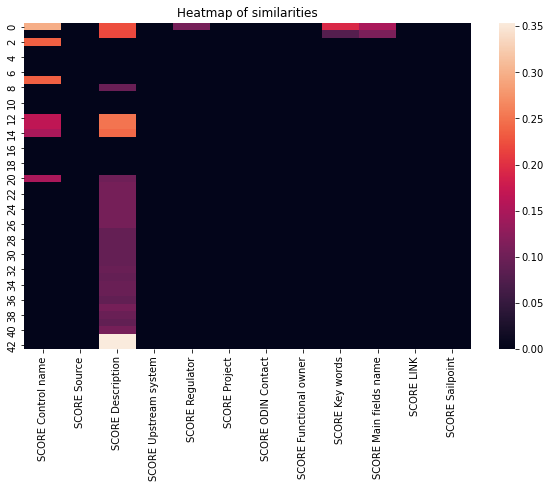

In [6]:
plt.figure(figsize = (10,6))
sns.heatmap(df_scores)
plt.title("Heatmap of similarities")
plt.show()

In [10]:
def get_control_name(df, input_sentence, weights = "uniform", k = 4):
    """
    Returns : 
        df_final : (dataframe) df in which was added column 'SCORE' 
                representing the average of similarity scores.
        df_k_best : (dataframe) the top k control names based on 
                the column 'SCORE'.
    """
    
    df_out, df_scores = get_scores_df(df, input_sentence)
    
    if weights == "uniform":
        weights = np.ones(df.shape[1]) / df.shape[1]  
    
    df_final = df.copy()
    df_final['SCORE'] =  df_scores.values.dot(weights)
    df_k_best = df_final[['Control name', 'SCORE']].sort_values(by = 'SCORE', ascending = False)[:k]
    
    return df_k_best, df_final    

In [11]:
input_sentence = "Please send me the url of FINFRAG report"
df_k_best, df_final = get_control_name(df, input_sentence, weights = "uniform", k = 4)
df_k_best

,Control name,SCORE
16,FINFRAG GMDWH,0.038137
15,FINFRAG RS,0.038137
42,EMIR Missing LEI ETD - DEC,0.028391
41,EMIR Missing LEI ETD,0.028391


#### Bag of words

In [9]:
def create_bow(df): 
    
    bow = []
    
    for i in df.values.reshape(-1):
        if i==i:
            bow = bow + list(tokenize_sentence(i))
    bow = np.unique(bow)
    
    bow,_,_ = normalise_list_of_words(bow,bow)
    return bow

bow = create_bow(df)

In [10]:
def count_vectorizer(df, bow):
    
    X = []
    for entry in df.values.reshape(-1):
        if entry != entry:
                X.append([0]*len(bow))
        else : 
            tokenized = tokenize_sentence(entry)
            vectorized = []
            for word in bow : 
                a = str(entry).count(word)
                vectorized.append(a)
            X.append(vectorized)
    X = np.array(X)
    return X

vectorized_df = count_vectorizer(df, bow)

In [65]:
def compute_similarities(input_sentence, df, bow):
    
    vectorized_df = count_vectorizer(df, bow)
    query = []
    tokenized = tokenize_sentence(input_sentence)
    for word in bow : 
        a = str(tokenized).count(word)
        query.append(a)
    query = np.array(query).reshape(-1,1)
    
    np.linalg.norm(vectorized_df, axis = 1) + 1e-6
    vectorized_df_normalized = vectorized_df / (np.linalg.norm(vectorized_df, axis = 1) + 1e-6).reshape(-1,1) 
    query_normalized = query / (np.linalg.norm(query, axis = 1) + 1e-6).reshape(-1,1) 
    similarities = vectorized_df_normalized.dot(query_normalized).reshape(df.shape[0], df.shape[1])
    
    return pd.DataFrame(similarities, columns = df.columns)


In [66]:
input_sentence = "Kpis Jurisdictions Canada daily It's KPI summing up all volumes The goal of this control is to verify if a"
df_scores = compute_similarities(input_sentence, df, bow)
df_final = pd.DataFrame()
df_final['Control name'] = df['Control name']
df_final['SCORE'] = df_scores.sum(axis = 1) 

(516, 300)


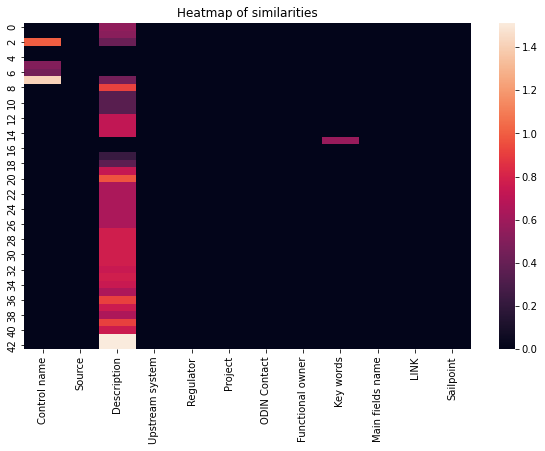

In [59]:
plt.figure(figsize = (10,6))
sns.heatmap(df_scores)
plt.title("Heatmap of similarities")
plt.show()

In [60]:
df_k_best = df_final[['Control name', 'SCORE']].sort_values(by = 'SCORE', ascending = False)[:4]
df_k_best

,Control name,SCORE
7,CCMC control,1.861424
42,EMIR Missing LEI ETD - DEC,1.511856
41,EMIR Missing LEI ETD,1.511856
2,LIBOR Control,1.408246


In [61]:
input_sentence

"Kpis Jurisdictions Canada daily It's KPI summing up all volumes The goal of this control is to verify if a"

In [62]:
df[df['Control name'] == 'LIBOR Control'].values

array([['LIBOR Control', 'SSRS',
        'The aim is to screen the LIBOR product trade this year', 'ALL',
        nan, 'TRUST', 'ABO', 'EB', 'LIBOR,SOR',
        'FLOATING_RATE_INDEX,UNDERLYING_MDS', 'https://ANONYMSED_3', nan]],
      dtype=object)